In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# classes and functions from 'util'
from util.data_load import returns_load
from util.GarchEstimator import GarchEstimator

In [2]:
start_dt = '2000-01-01'
end_dt = '2020-03-01'
ticker = 'MSFT' 
interval = '1d'
garch_init = {
    'alpha' : 0.7,
    'beta1' : 0.3,
    'beta2' : 0.1,
    'omega1' : 0.01,
    'omega2' : 0.01,
    'omega3' : 0.01
}

In [3]:
ret_data = returns_load(ticker=ticker,
                    interval=interval,
                    start_dt=start_dt,
                    end_dt=end_dt)

[*********************100%***********************]  1 of 1 completed


In [8]:
garch =  GarchEstimator(theta_init = garch_init)

In [9]:
ret_data['garch'] = garch.fit_data(
    method='GARCH',
    data_estimate=ret_data['return']*100,
    data_fit=ret_data['return']*100
    
)
print(garch.get_estimates(coef=True, llik=True))

`xtol` termination condition is satisfied.
Number of iterations: 465, function evaluations: 3038, CG iterations: 1361, optimality: 5.55e-04, constraint violation: 0.00e+00, execution time: 3.1e+02 s.
Model recalculated!
 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 1361
      cg_stop_cond: 4
            constr: [array([1.72537362e-01, 1.10906902e-01, 8.65658474e-02, 7.80671466e-06,
       4.79330203e-01, 2.81250032e-01])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 307.9657998085022
               fun: 9766.09531323833
              grad: array([-4.02832031e-03, -3.41796875e-03, -4.88281250e-03,  5.17895508e+00,
       -2.80761719e-03, -7.56835938e-03])
               jac: [<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-1.16451627e-04, -4.15315

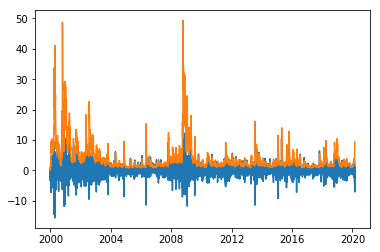

In [11]:
x = ret_data['dt']
y1 = ret_data['return']*100
y2 = ret_data['garch']
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()